In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import threading
import queue
import os
from typing import TypeVar, Dict, Callable, Tuple, Union, List, Generic
Fn = Callable

%matplotlib inline
%load_ext line_profiler

In [2]:
Action = int
Player = int
State = TypeVar('State')
c_puct = 1.0
dirichlet_eps = 0.25
dirichlet_alpha = 0.3

def sample(it):
    rand = np.random.sample()
    t = 0.0
    if isinstance(it, dict):
        it = it.items()
    else:
        it = enumerate(it)
    for i, f in it:
        t = t + f
        if rand <= t:
            return i
        
debug = False
    
class MCTSNode(Generic[State]):
    def __init__(self, state: State, probs: np.ndarray, v: float, player: Player) -> None:
        self.state: State = state
        self.player = player
        if not np.any(probs):
            self.terminal = True
            self.value = v
            return
        
        self.terminal = False
        self.actions = np.flatnonzero(probs)
        self.inv_actions = np.empty_like(probs, dtype=np.int)
        self.inv_actions[self.actions] = np.arange(self.actions.size)
        
        self.N: np.ndarray = np.zeros_like(self.actions, dtype=np.int)
        self.W: np.ndarray = np.zeros_like(self.actions, dtype=np.float)
        self.Q: np.ndarray = np.zeros_like(self.actions, dtype=np.float)
        self.P: np.ndarray = probs[self.actions]
        
        self.total_visits: int = 1
        self.children: List[MCTSNode] = [None] * probs.size
            
    def select_action(self) -> Action:
        if not self.actions.size:
            return None
        
        root_total = math.sqrt(self.total_visits)
        
        selection_priorities = self.Q + c_puct * root_total * self.P / (1 + self.N)
        if debug:
            print(self.state, selection_priorities)
        return self.actions[np.argmax(selection_priorities)]
    
    def backup(self, a, v, p):
        self.total_visits = self.total_visits + 1
        idx = self.inv_actions[a]
        self.N[idx] = self.N[idx] + 1
        self.W[idx] = self.W[idx] + (v if p == self.player else -v)
        self.Q[idx] = self.W[idx] / self.N[idx]
    
    def probs(self, temp) -> np.ndarray:
        if temp == 0.0:
            ret = np.zeros_like(self.inv_actions)
            ret[self.actions[np.argmax(self.N)]] = 1.0
            return ret
        exps = self.N ** (1.0 / temp)
        ret = np.zeros_like(self.inv_actions, dtype=np.float)
        ret[self.actions] = exps / np.sum(exps)
        return ret
    
class Game(Generic[State]):
    def __init__(self):
        self.num_players = 2
    def gen_root(self) -> State:
        raise NotImplemented   
    def do_action(self, state: State, action: Action) -> Tuple[State, Player]:
        raise NotImplemented   
    def get_actions(self, state: State, player: Player) -> List[Action]:
        raise NotImplemented
    def num_actions(self) -> int:
        raise NotImplemented
    def end(self, state: State, player: Player) -> Player:
        raise NotImplemented
    
class MCTSPlayer(Generic[State]):
    def __init__(self,
                 game: Game[State],
                 eval_state: Fn[[State, Player], Tuple[np.ndarray, float]]):
        self.game = game
        self.eval_state = eval_state
        
    def take_turn(self, root_node: MCTSNode, search_size: int) -> MCTSNode:
        for _ in range(search_size):
            cur_node = root_node
            history: List[Tuple[MCTSNode, Action]] = []

            while cur_node and not cur_node.terminal:
                action = cur_node.select_action()
                history.append((cur_node, action))
                cur_node = cur_node.children[action]

            value: float
            player: int
            if cur_node:
                value = cur_node.value
                player = cur_node.player
            else:
                prev_node = history[-1][0]
                action = history[-1][1]
                new_state, player = self.game.do_action(
                    prev_node.state, action, prev_node.player)
                probs, value = self.eval_state(new_state, player)
                new_node = MCTSNode(new_state, probs, value, player)
                prev_node.children[action] = new_node

            for i, (node, act) in enumerate(reversed(history)):
                node.backup(act, value, player)
    
    def play_self(self, search_size: int, temp: float = 0.0) -> List[Tuple[State, np.ndarray, float, Player]]:
        root_state, root_player = self.game.gen_root()
        probs, value = self.eval_state(root_state, root_player)
        probs = ((1 - dirichlet_eps) * probs + 
                 dirichlet_eps * np.random.dirichlet(np.full_like(probs, dirichlet_alpha)))
        cur_node = MCTSNode(root_state, probs, value, root_player)
        history: List[Tuple[State, np.ndarray]] = []
        
        while not cur_node.terminal:
            self.take_turn(cur_node, search_size)
            probs = cur_node.probs(temp)
            next_act = sample(probs)
            
            history.append((cur_node, probs))
            
            cur_node = cur_node.children[next_act]
            
        history.append((cur_node, None))
        r = cur_node.value
        fin_player = cur_node.player
        
        return list(reversed([(n.state, p, r if n.player == fin_player else -r, n.player)
                              for i, (n, p) in enumerate(reversed(history))]))


In [3]:
TTTState = Tuple[np.ndarray, int]

class TTT(Game[TTTState]):
    _board_shape = (9,)
    
    def __init__(self):
        super().__init__()
        
    def gen_root(self) -> Tuple[TTTState, Player]:
        return np.zeros(TTT._board_shape, dtype=np.int), 1

    def do_action(self, s: TTTState, a: Action, p: Player) -> Tuple[TTTState, Player]:
        new_board = np.copy(s)
        new_board[a] = p
        return (new_board, -p)

    def get_actions(self, board: TTTState, _: Player) -> np.ndarray:
        return np.nonzero(board == 0)[0]
    
    def num_actions(self) -> int:
        return 9

    _end_idx = sum([[3 * i, 3 * i + 1, 3 * i + 2, i, i + 3, i + 6 ] for i in range(3)], [])
    _end_idx = np.array(_end_idx + [2, 4, 6, 0, 4, 8])
    _inv_end_idx = np.array(sum([[3 * i, i] for i in range(3)], []) + [2, 0])
    def end(self, board: TTTState, player: Player) -> Player:
        z = np.flatnonzero(np.abs(np.sum(board[TTT._end_idx].reshape(8, 3), axis=1)) == 3)
        if z.size:
            return board[TTT._inv_end_idx[z[0]]] * player

        if np.all(board):
            return 0.0

        return None
    
ttt = TTT()
def ttt_eval_state(s: TTTState, p: Player) -> Tuple[np.ndarray, float]:
    end = ttt.end(s, p)
    if end != None:
        return (np.zeros(TTT._board_shape), end)
    acts = np.zeros(TTT._board_shape)
    valid_acts = ttt.get_actions(s, p)
    acts[valid_acts] = 1.0 / valid_acts.size
    return (acts, 0.0)

Wall time: 4.69 s


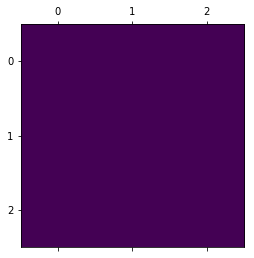

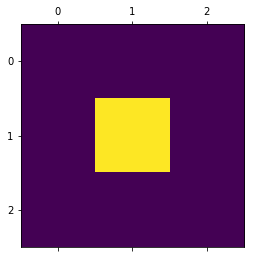

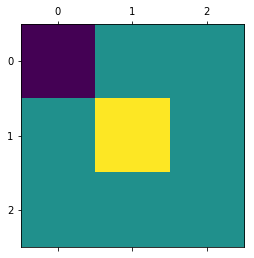

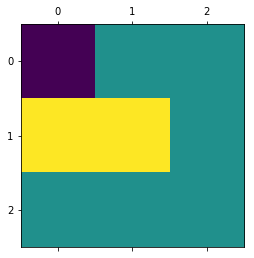

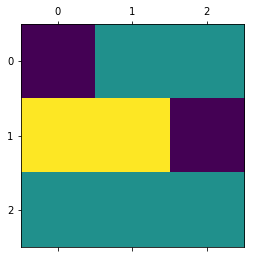

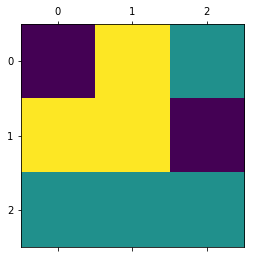

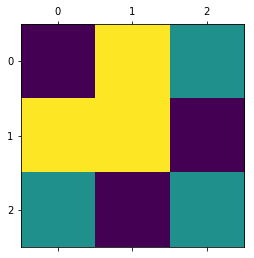

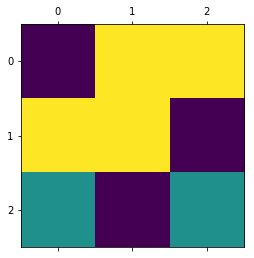

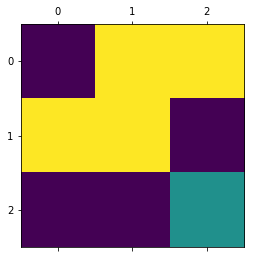

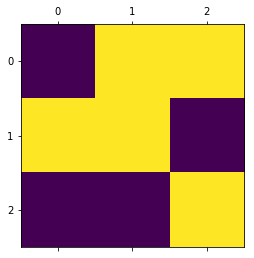

In [4]:
%%time

for s, _, _, _ in MCTSPlayer(ttt, ttt_eval_state).play_self(10000):
    plt.matshow(s.reshape(3, 3))

In [5]:
example_search_len = 20

def unzip(list_of_tuples):
    unzipped_as_tuples = list(zip(*list_of_tuples))
    return tuple([list(tup) for tup in unzipped_as_tuples])

class Model(Generic[State]):
    def __init__(self, game: Game[State]):
        self.game = game
    
    PARAMS_TRAIN = 0
    PARAMS_BEST = 1
    
    def eval_states(self, 
                    states: List[State],
                    players: List[Player],
                    using=PARAMS_BEST) -> Tuple[np.ndarray, np.ndarray]:
        pass
    
    def eval_state(self, state: State, player: Player, using=PARAMS_BEST) -> Tuple[np.ndarray, float]:
        end = self.check_end(state, player)
        if end:
            return end
        a, v = self.eval_states([state], [player], using)
        return a[0], v[0]
    
    def check_end(self, state: State, player:Player) -> Tuple[np.ndarray, float]:
        end = self.game.end(state, player)
        if end != None:
            return (np.zeros(self.game.num_actions()), end)
        return None
    
    def train(self, batch_size=64, num_iters=1000):
        pass
    
    def add_data(self, 
                 states: List[State], 
                 probs: List[np.ndarray],
                 rewards: List[float],
                 players: List[int]):
        pass

class ExpertIterationTrainer(Generic[State]):
    def __init__(self,
                 model: Model[State],
                 num_iterations: int,
                 iteration_size: int = 100,
                 search_size: int = 100):
        self.model = model
        self.game = self.model.game
        self.num_iterations = num_iterations
        self.iteration_size = iteration_size
        self.search_size = search_size
              
    def train_player(self):
        player = MCTSPlayer(self.game, 
                            lambda s, p: self.model.eval_state(s, p))
        example_games = [player.play_self(example_search_len)]
        
        for i in range(1, self.num_iterations + 1):
            example_games.append(player.play_self(example_search_len))
            new_probs = [self.model.eval_state(res[0], res[3]) for res in example_games[-1]]
            example_probs = [new_probs]
            
            states, probs, rewards, players = self.play_games()
                
            self.model.add_data(states, probs, rewards, players)
            self.model.train()

            print('finished step %d' % i)

        example_games.append(player.play_self(example_search_len))
        new_probs = [self.model.eval_state(res[0], res[3]) for res in example_games[-1]]
        example_probs.append(new_probs)

        return example_games#, all_states, all_labels, example_probs
    

    def play_games(self) -> Tuple[List[State], 
                                  List[np.ndarray], 
                                  List[float], 
                                  List[int]]:
        work_q = queue.Queue()
        result_q = queue.Queue()
        go = queue.Queue()
        alive = [self.iteration_size]
        in_q = [0]
        counter_lock = threading.Lock()
        
        def mp_play_self():
            my_q = queue.Queue()

            def eval_state(state: State, p: Player) -> Tuple[np.ndarray, float]:
                with counter_lock:
                    work_q.put(((state, p), my_q))
                    in_q[0] += 1
                    if alive[0] == in_q[0]:
                        go.put(True)
                return my_q.get()

            player = MCTSPlayer(self.game, eval_state)
            result = player.play_self(self.search_size, 1.0)
            with counter_lock:
                alive[0] -= 1
                result_q.put(result)
                if alive[0] == 0:
                    go.put(False)
                elif alive[0] == in_q[0]:
                    go.put(True)
        
        for _ in range(self.iteration_size):
            threading.Thread(target=mp_play_self).start()

        while go.get():
            with counter_lock:
                ret_qs = []
                states = []
                players = []
                for _ in range(in_q[0]):
                    (state, player), ret_q = work_q.get_nowait()
                    end = self.game.end(state, player)
                    if end != None:
                        ret_q.put((np.zeros(self.game.num_actions()), end))
                    else: 
                        ret_qs.append(ret_q)
                        states.append(state)
                        players.append(player)
                in_q[0] = 0
                if len(states) > 0:
                    a, v = self.model.eval_states(states, players, using=Model.PARAMS_BEST)
                    for j, ret_q in enumerate(ret_qs):
                        ret_q.put((a[j], v[j]))
                        
        positions = []
        while not result_q.empty():
            positions += result_q.get_nowait()[:-1]
        return unzip(positions)


In [6]:
def softmax(x):
    if len(x.shape) == 1:
        exped = np.exp(x - np.max(x))
        return exped / exped.sum()
    else:
        mx = np.max(x, axis=1)
        mx = mx.reshape((1,) + mx.shape).transpose()
        exped = np.exp(x - mx)
        denom = np.sum(exped, axis=1)
        denom = denom.reshape((1,) + denom.shape).transpose()
        return exped / denom

class TTTModel(Model[TTTState]):
    game = TTT()
    
    l2_loss_coeff = 0.01
    hidden_size = 100
    search_size = 100

    graph = tf.Graph()
    with graph.as_default():
        ttt_hw = tf.Variable(tf.truncated_normal([9, hidden_size]))
        ttt_hb = tf.Variable(tf.zeros([hidden_size]))
    
        ttt_aw = tf.Variable(tf.truncated_normal([hidden_size, 9]))
        ttt_ab = tf.Variable(tf.zeros([9]))

        ttt_vw = tf.Variable(tf.truncated_normal([hidden_size, 1]))
        ttt_vb = tf.Variable(tf.zeros([1]))

        weights = [ttt_hw, ttt_hb, ttt_aw, ttt_ab, ttt_vw, ttt_vb]
        saver = tf.train.Saver(weights)

        tf_boards = tf.placeholder(tf.float32, shape=[None, 9])
        hidden = tf.nn.relu(tf.matmul(tf_boards, ttt_hw) + ttt_hb)
        actions = tf.matmul(hidden, ttt_aw) + ttt_ab
        value = tf.tanh(tf.matmul(hidden, ttt_vw) + ttt_vb)

        tf_probs = tf.placeholder(tf.float32, shape=[None, 9])
        tf_zs = tf.placeholder(tf.float32, shape=[None])

        loss = tf.reduce_mean(tf.square(tf_zs - value))
        loss = loss + tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=tf_probs, logits=actions))
        for w in weights:
            loss = loss + l2_loss_coeff * tf.nn.l2_loss(w)

        optimizer = tf.train.AdamOptimizer().minimize(loss)
        
    chkpnt_folder = os.path.join('.', 'checkpoints')
    if not os.path.exists(chkpnt_folder):
        os.makedirs(chkpnt_folder)
    chkpnt_file = os.path.join(chkpnt_folder, 'ttt')    
        
    def __init__(self):
        super().__init__(self.game)
        
        self.states = np.empty((0, 9))
        self.probs = np.empty((0, 9))
        self.rewards = np.empty((0,))
        self.players = np.empty((0,), dtype=np.int)
        
        self.train_step = 0
        self.x_player = None
        self.o_player = None
        self.train_sess = None
        self.best_sess = None
        self.best_chkpnt = None
        
    def __enter__(self):
        self.train_sess = tf.Session(graph=self.graph)
        self.best_sess = tf.Session(graph=self.graph)
        self.train_sess.__enter__()
        self.best_sess.__enter__()
        
        self.train_sess.run(tf.global_variables_initializer())
        self.best_chkpnt = self.saver.save(self.train_sess, self.chkpnt_file, 0)
        self.saver.restore(self.best_sess, self.best_chkpnt)
        
        def eval_as_x(s, p):
            return self.eval_state(s, p, using=Model.PARAMS_TRAIN if p == 1 else Model.PARAMS_BEST)
        self.x_player = MCTSPlayer(self.game, eval_as_x)
        def eval_as_o(s, p):
            return self.eval_state(s, p, using=Model.PARAMS_BEST if p == 1 else Model.PARAMS_TRAIN)
        self.o_player = MCTSPlayer(self.game, eval_as_o)
        
        return self
        
    def __exit__(self, tp, val, traceback):
        self.best_sess.__exit__(tp, val, traceback)
        self.train_sess.__exit__(tp, val, traceback)
        
    def eval_states(self, 
                    states: List[TTTState],
                    players: List[Player],
                    using=Model.PARAMS_BEST) -> Tuple[np.ndarray, np.ndarray]:
        feed = { self.tf_boards: np.array(states) }
        sess = self.best_sess if using == Model.PARAMS_BEST else self.train_sess
        actions, value = sess.run([self.actions, self.value], feed_dict=feed)
        for i in range(actions.shape[0]):
            action = actions[i]
            poss_actions = self.game.get_actions(states[i], players[i])
            mask = np.ones_like(action, dtype=bool)
            mask[poss_actions] = False
            action[mask] = 0.0
            action[poss_actions] = softmax(action[poss_actions])

        return (actions, value)
    
    def eval_state(self, state: State, player: Player, using=Model.PARAMS_BEST) -> Tuple[np.ndarray, float]:
        end = self.check_end(state, player)
        if end:
            return end
        a, v = self.eval_states([state], [player], using)
        return a[0], v[0]
    
    def check_end(self, state: State, player:Player) -> Tuple[np.ndarray, float]:
        end = self.game.end(state, player)
        if end != None:
            return (np.zeros(self.game.num_actions()), end)
        return None
    
    def train(self, batch_size=64, num_iters=1000):
        self.train_step += 1
        
        for i in range(1000):
            select = np.random.choice(np.arange(len(self.states)), 64)

            feed = {
                self.tf_boards: self.states[select],
                self.tf_probs: self.probs[select],
                self.tf_zs: self.rewards[select]
            }
            
            self.train_sess.run(self.optimizer, feed_dict=feed)
                
        if self.train_is_better():
            self.best_chkpnt = self.saver.save(self.train_sess, self.chkpnt_file, self.train_step)
            self.saver.restore(self.best_sess, self.best_chkpnt)
        else:
            self.saver.restore(self.train_sess, self.best_chkpnt)

    def train_is_better(self):
        tot_games = 10
        x_reward = 0
        o_reward = 0
        for i in range(tot_games):
            x_reward += self.x_player.play_self(self.search_size)[0][2]
            o_reward -= self.o_player.play_self(self.search_size)[0][2]
        
        avg_reward = (x_reward + o_reward) / (2 * tot_games)
        print(x_reward, o_reward, avg_reward)
        return avg_reward > 0.1
            
    
    def add_data(self, 
                 states: List[TTTState], 
                 probs: List[np.ndarray],
                 rewards: List[float],
                 players: List[int]):
        self.states = np.concatenate([self.states, states])
        self.probs = np.concatenate([self.probs, probs])
        self.rewards = np.concatenate([self.rewards, rewards])
        self.players = np.concatenate([self.players, players])



INFO:tensorflow:Restoring parameters from .\checkpoints\ttt-0
10 -10 0.0
INFO:tensorflow:Restoring parameters from .\checkpoints\ttt-0
finished step 1
0.0 -7.0 -0.35
INFO:tensorflow:Restoring parameters from .\checkpoints\ttt-0
finished step 2
0.0 -10 -0.5
INFO:tensorflow:Restoring parameters from .\checkpoints\ttt-0
finished step 3
10 2 0.6
INFO:tensorflow:Restoring parameters from .\checkpoints\ttt-4
finished step 4
10 -9.0 0.05
INFO:tensorflow:Restoring parameters from .\checkpoints\ttt-4
finished step 5
Wall time: 1min 26s


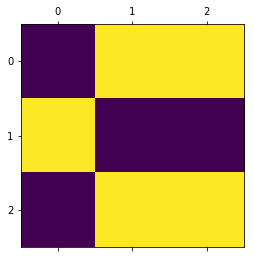

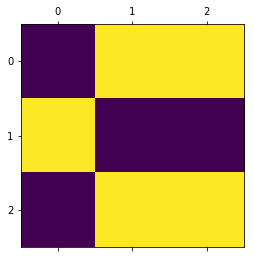

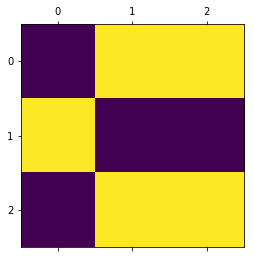

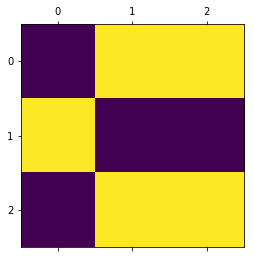

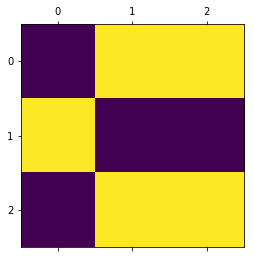

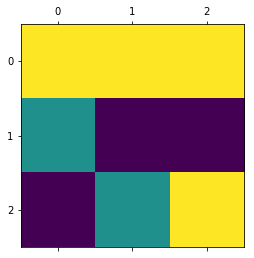

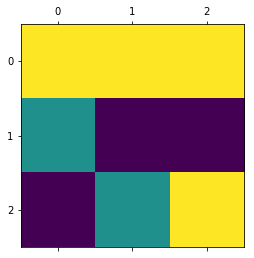

In [7]:
%%time

with TTTModel() as model:
    trainer = ExpertIterationTrainer(model, 5)
    examples = trainer.train_player()#, states, labels, probs = trainer.train_player()

for g in examples[::1]:
    plt.matshow(g[-1][0].reshape(3, 3))